<a href="https://colab.research.google.com/github/lanhhv84/fastai/blob/master/nbs/dl2/01_matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

## Check imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import sys

sys.path.append('/content/drive/My Drive/DS/fastai/nbs/dl2')

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=1850)

In [0]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [0]:
test_eq(TEST,'test')

In [0]:
# To run tests in console:
# ! python run_notebook.py 01_matmul.ipynb

## Get data

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=2159)

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [9]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [11]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
assert n == y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
img = x_train[0]

In [15]:
img.view(28,28).type()

'torch.FloatTensor'

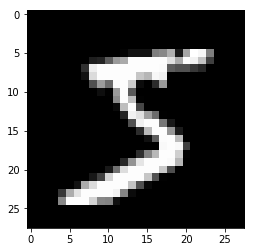

In [16]:
plt.imshow(img.view((28,28)));

## Initial python model

 [Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=2342)

 [Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=2342)

In [0]:
weights = torch.randn(784,10)

In [0]:
bias = torch.zeros(10)

#### Matrix multiplication

In [0]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

In [0]:
m1 = x_valid[:5]
m2 = weights

In [21]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [22]:
%time t1=matmul(m1, m2)

CPU times: user 714 ms, sys: 0 ns, total: 714 ms
Wall time: 714 ms


In [23]:
t1.shape

torch.Size([5, 10])

This is kinda slow - what if we could speed it up by 50,000 times? Let's try!

In [24]:
len(x_train)

50000

#### Elementwise ops

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

 [Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=2682)

In [25]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [26]:
a + b

tensor([12., 14.,  3.])

In [27]:
(a < b).float().mean()

tensor(0.6667)

In [28]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste.

In [29]:
(m*m).sum().sqrt()

tensor(16.8819)

#### Elementwise matmul

In [0]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [31]:
%timeit -n 10 _=matmul(m1, m2)

10 loops, best of 3: 1.09 ms per loop


In [34]:
714/1.09

655.0458715596329

In [0]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [0]:
test_near(t1,matmul(m1, m2))

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=3110)

#### Broadcasting with a scalar

In [37]:
a

tensor([10.,  6., -4.])

In [38]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [39]:
a + 1

tensor([11.,  7., -3.])

In [40]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [41]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [42]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [43]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [44]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [45]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [46]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [0]:
t = c.expand_as(m)

In [48]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [49]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [50]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [51]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [52]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [56]:
c.unsqueeze(1), c.unsqueeze(-1) == c[:, None]

(tensor([[10.],
         [20.],
         [30.]]), tensor([[1],
         [1],
         [1]], dtype=torch.uint8))

In [57]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [59]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape,c.unsqueeze(-1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]), torch.Size([3, 1]))

In [61]:
c.shape, c[None].shape,c[:,None].shape, c[None,...].shape, c[...,None].shape

(torch.Size([3]),
 torch.Size([1, 3]),
 torch.Size([3, 1]),
 torch.Size([1, 3]),
 torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [62]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [63]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [64]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [65]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

#### Matmul with broadcasting

In [0]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
# row = row*mat
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
    return c

In [67]:
%timeit -n 10 _=matmul(m1, m2)

10 loops, best of 3: 247 µs per loop


In [70]:
714/247/1e-3

2890.6882591093117

In [0]:
test_near(t1, matmul(m1, m2))

#### Broadcasting Rules

In [72]:
c[None,:]

tensor([[10., 20., 30.]])

In [73]:
c[None,:].shape

torch.Size([1, 3])

In [74]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [75]:
c[:,None].shape

torch.Size([3, 1])

In [76]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [77]:
c[None] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=4280)

In [0]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [79]:
%timeit -n 10 _=matmul(m1, m2)

The slowest run took 100.74 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 30.9 µs per loop


In [82]:
741/31/1e-3

23903.22580645161

In [0]:
test_near(t1, matmul(m1, m2))

### pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=4702)

In [84]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 96.05 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 7.2 µs per loop


In [86]:
# time comparison vs pure python:
714/7.2/1e-3

99166.66666666666

In [0]:
t2 = m1@m2

In [0]:
test_near(t1, t2)

In [89]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

## Export

In [90]:
!python notebook2script.py 01_matmul.ipynb

python3: can't open file 'notebook2script.py': [Errno 2] No such file or directory
